In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('combined_traj_data.csv')

In [3]:
# Feature engineering
df['speed'] = np.sqrt(df['vx']**2 + df['vy']**2)
df['heading'] = np.arctan2(df['vy'], df['vx'])
df['accel'] = df['speed'].diff() / df['t'].diff()
df['turn_rate'] = df['heading'].diff() / df['t'].diff()
df['distance'] = np.sqrt(df['x'].diff()**2 + df['y'].diff()**2)

features = df[['speed', 'heading', 'accel', 'turn_rate', 'distance']]

In [ ]:
features['accel'].fillna(0, inplace=True)
features['turn_rate'].fillna(0, inplace=True)
features['distance'].fillna(0, inplace=True)

In [5]:
features.head()

,speed,heading,accel,turn_rate,distance
0,14.1,1.186824,0.000000,0.000000e+00,0.000000
1,14.0,1.186824,-0.001587,-2.819614e-17,0.004410
2,14.1,1.186824,0.004545,8.074349e-17,0.001710
3,14.0,1.186824,-0.003448,-6.125368e-17,0.001645
4,14.0,1.186824,0.000000,0.000000e+00,0.005133


In [6]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
y_pr = lof.fit_predict(features)

In [7]:
inlier_indices = y_pr == 1
features_no_outliers = features[inlier_indices]

In [8]:
features_no_outliers = features_no_outliers.reset_index(drop=True)

In [9]:
features_no_outliers.head()

,speed,heading,accel,turn_rate,distance
0,14.1,1.186824,0.004545,8.074349e-17,0.001710
1,14.1,1.186824,0.000327,5.805088e-18,0.021769
2,14.1,1.186824,0.000000,0.000000e+00,0.000922
3,14.1,1.186824,0.000000,0.000000e+00,0.000428
4,14.1,1.186824,0.000000,0.000000e+00,0.001717


In [10]:
# Cluster trajectories
kmeans = KMeans(n_clusters=5)
features_no_outliers['cluster'] = kmeans.fit_predict(features_no_outliers)

# Identify normal cluster
cluster_list = features_no_outliers['cluster'].tolist()
normal_cluster = max(set(cluster_list), key=cluster_list.count)

D:\softswar\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


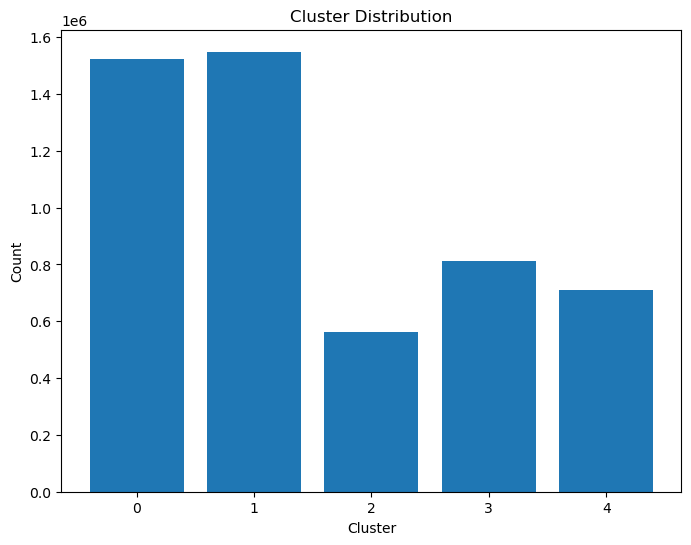

In [11]:
import matplotlib.pyplot as plt
# Count the occurrences of each cluster
cluster_counts = features_no_outliers['cluster'].value_counts()

# Create a bar chart to visualize the cluster distribution
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution')
plt.xticks(cluster_counts.index)
plt.show()

In [12]:
normal_df = features_no_outliers[features_no_outliers['cluster'] == normal_cluster]

In [13]:
normal_df.head()

,speed,heading,accel,turn_rate,distance,cluster
742,12.0,-0.802851,-0.001504,-1.181050e-03,0.009926,1
743,11.9,-0.680678,-0.001010,1.234071e-03,0.007215,1
744,12.1,-0.802851,0.001389,-8.484239e-04,0.010940,1
745,11.8,-0.802851,-0.002206,2.449021e-18,0.010575,1
746,11.7,-0.733038,-0.000826,1.009695e-03,0.009199,1


In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normal_features = scaler.fit_transform(normal_df[['speed', 'heading', 'accel', 'turn_rate', 'distance']])

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
svm = OneClassSVM(nu=0.05)
X_train, X_test = train_test_split(normal_features, test_size=0.2)

In [16]:
svm.fit(X_train)

OneClassSVM(nu=0.05)

In [17]:
y_pred = svm.predict(X_test)

In [18]:
print('Accuracy:', np.mean(y_pred == 1))

Accuracy: 0.95
